# Classification foliar diseases in apple trees

## Import Packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import cv2
import pathlib
import os
import random
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt 
import glob as gb
from kaggle_datasets import KaggleDatasets
!pip install -q efficientnet
import efficientnet.tfkeras as efn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

## Preprocessing Dataset Images

In [2]:
dataset_folder = os.path.join("/kaggle/input/plant-pathology-2020-fgvc7")

In [3]:
datasetObject = pd.read_csv(os.path.join(dataset_folder, "train.csv"))
datasetObject.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [4]:
imagesDataset = pathlib.Path(os.path.join(dataset_folder, "images"))
listImages = list(imagesDataset.glob("*.*"))

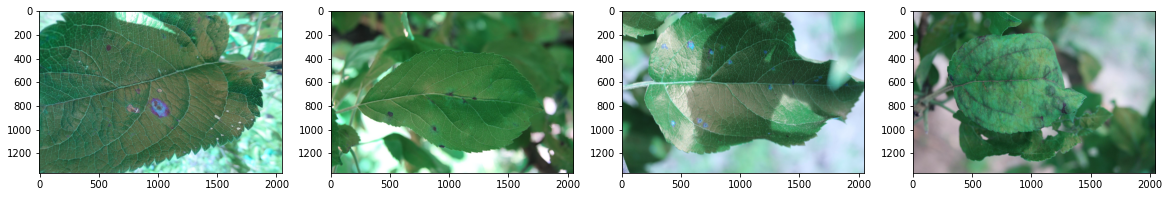

In [5]:
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = cv2.imread(str(listImages[i]))
    plt.imshow(img)
plt.show()

In [6]:
images_id_csv = datasetObject['image_id']
healthy_csv = datasetObject['healthy']
multiple_diseases_csv = datasetObject['multiple_diseases']
rust_csv = datasetObject['rust']
scab_csv = datasetObject['scab']

In [7]:
images = []
labels = []
for index, values in enumerate(images_id_csv):
    img = cv2.imread(os.path.join(dataset_folder, "images", "{}.jpg".format(values)))
    img = cv2.resize(img, (100, 100))
    img = img/255
    labels.append([healthy_csv[index], multiple_diseases_csv[index], rust_csv[index],
                 scab_csv[index]])
    images.append(img)

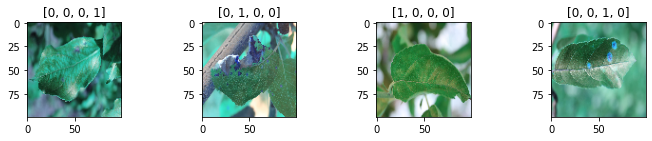

In [8]:
plt.figure(figsize = (12, 8))
for i in range(4):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

In [9]:
img_data_g = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.35,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rescale=None)

## Images Data Augentation

In [10]:
images_after_aug = []
labels_after_aug = []
for index, image in enumerate(images):
  for i in range(5):
      img = img_data_g.flow(np.reshape(image, (1, 100, 100, 3))).next()
      images_after_aug.append(np.reshape(img, (100, 100, 3)))
      labels_after_aug.append(labels[index])
labels = np.asarray(labels_after_aug)
images = np.asarray(images_after_aug)

In [11]:
images.shape

(9105, 100, 100, 3)

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


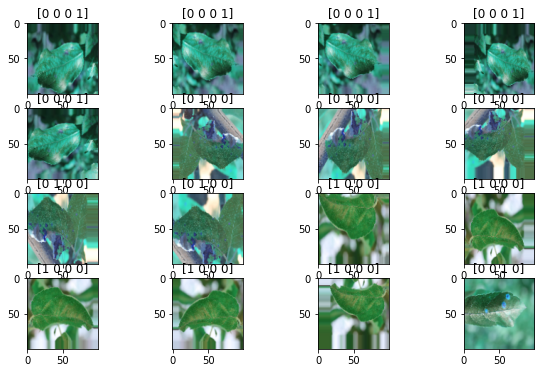

In [12]:
plt.figure(figsize = (10, 6))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

In [13]:
def Eff_B7_NS():
    model_EfficientNetB7_NS = Sequential([efn.EfficientNetB7(input_shape=(100,100,3),weights='noisy-student',include_top=False),
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dense(128,activation='relu'),
                                 tf.keras.layers.Dense(64,activation='relu'),
                                 tf.keras.layers.Dense(4,activation='softmax')])               
    model_EfficientNetB7_NS.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics=["accuracy", Precision(name='precision'), Recall(name='recall')])
    
    
    return model_EfficientNetB7_NS

In [14]:
m=Eff_B7_NS()

258080768/258068648 [==============================] - 1s 0us/step


In [15]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 4, 4, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               327808    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 64,434,004
Trainable params: 64,123,284
Non-trainable params: 310,720
_________________________________________________________________


In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 43)

In [17]:
x_train.shape

(7739, 100, 100, 3)

In [18]:
x_test.shape

(1366, 100, 100, 3)

## Train Model

In [19]:
history = m.fit(x_train, y_train, epochs = 50, batch_size = 32,
                callbacks = [
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, mode = 'min',
                                                  patience= 1),
                    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min', restore_best_weights = True)
                ])

Epoch 1/50
242/242 [==============================] - 113s 318ms/step - loss: 1.2634 - accuracy: 0.3681 - precision: 0.4335 - recall: 0.0636
Epoch 2/50
242/242 [==============================] - 76s 314ms/step - loss: 0.7372 - accuracy: 0.7373 - precision: 0.7963 - recall: 0.6598
Epoch 3/50
242/242 [==============================] - 76s 315ms/step - loss: 0.3659 - accuracy: 0.8915 - precision: 0.9087 - recall: 0.8772
Epoch 4/50
242/242 [==============================] - 77s 317ms/step - loss: 0.2505 - accuracy: 0.9227 - precision: 0.9350 - recall: 0.9102
Epoch 5/50
242/242 [==============================] - 76s 316ms/step - loss: 0.2115 - accuracy: 0.9313 - precision: 0.9421 - recall: 0.9209
Epoch 6/50
242/242 [==============================] - 76s 314ms/step - loss: 0.1651 - accuracy: 0.9440 - precision: 0.9502 - recall: 0.9378
Epoch 7/50
242/242 [==============================] - 76s 315ms/step - loss: 0.1310 - accuracy: 0.9580 - precision: 0.9614 - recall: 0.9550
Epoch 8/50
242/242 

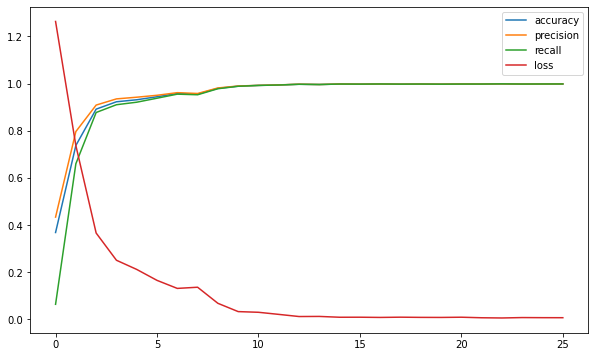

In [20]:
plt.figure(figsize = (10, 6))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['precision'], label = "precision")
plt.plot(history.history['recall'], label = "recall")
plt.plot(history.history['loss'], label = "loss")
plt.legend()

In [21]:
m.evaluate(x_test, y_test, batch_size= 32)

43/43 [==============================] - 8s 91ms/step - loss: 0.0898 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744


[0.08975942432880402,
 0.9743777513504028,
 0.9743777513504028,
 0.9743777513504028]

In [22]:
y_pred = m.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

In [23]:
y_pred

array([3, 3, 2, ..., 2, 2, 3])

In [24]:
y_test = np.argmax(y_test, axis = 1)

In [25]:
cnn_standard_acc = accuracy_score(y_pred, y_test)
print(cnn_standard_acc)

0.9743777452415813


In [26]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       418
           1       0.76      0.80      0.78        66
           2       0.98      0.98      0.98       454
           3       0.99      0.98      0.98       428

    accuracy                           0.97      1366
   macro avg       0.93      0.94      0.93      1366
weighted avg       0.98      0.97      0.97      1366



In [27]:
def generate_confusion_matrix(y_pred, y_test):
    c = tf.math.confusion_matrix(y_pred, y_test)
    sns.heatmap(c, annot=True)

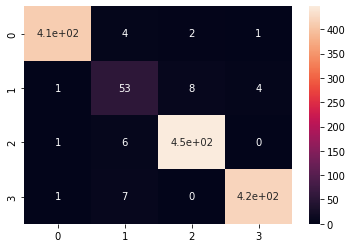

In [28]:
generate_confusion_matrix(y_pred, y_test)